In [43]:
from aaff import aaff,alc_deriv_grad_nuc,alc_differential_grad_nuc
from FcMole import FcM
from alch_deriv import alch_deriv
from pyscf import gto,scf
import numpy as np
import ipyvolume as ipv
from numpy.linalg import norm as norm
from scipy.optimize import  minimize
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pyscf.grad import rhf as grhf
from pyscf.hessian import rhf as hrhf
import basis_set_exchange as bse
from FDcoeffs import *
from pyscf.geomopt.berny_solver import optimize
ang2bohr=1.8897261246
bohr2ang=.5291772109

In [44]:
HF=gto.M(atom="F 0 0 0;H 0 0 1.695741",unit="bohr",
            basis={"H":"pc-2",'F':bse.get_basis("pcX-2",fmt="nwchem",elements=[9])})
mfhf = scf.RHF(HF)
mfhf.scf()
hf_eq=optimize(mfhf)

converged SCF energy = -100.065540168732

Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   F   0.000000   0.000000   0.000000    0.000000  0.000000  0.000000
   H   0.000000   0.000000   0.897347    0.000000  0.000000  0.000000
converged SCF energy = -100.065540168733
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 F    -0.0000000000    -0.0000000000    -0.0000009944
1 H     0.0000000000     0.0000000000     0.0000009944
----------------------------------------------
cycle 1: E = -100.065540169  dE = -100.066  norm(grad) = 1.40635e-06


In [45]:
dm=mfhf.make_rdm1()

In [46]:
dL=[-1,0]

In [47]:
def Vne(coords,mol=HF,dm=dm):
    mol.set_rinv_orig_(coords)
    dV=mol.intor('int1e_rinv')
    return -np.einsum('ij,ij',dV,dm)

In [48]:
Vne([0,.5,-1.3],HF,dm)

-6.6249829541825775

In [49]:
def Vnn(coords,mol=HF):
    Vnn=0
    for i in range (mol.natm):
        Vnn+= (mol.atom_charge(i)+dL[i])/np.linalg.norm(coords-mol.atom_coord(i))
    return Vnn

In [50]:
Vnn([0,.5,-1.3],HF)

6.072918030765468

In [51]:
def Vtot(coords):
    return Vnn(coords,HF)+Vne(coords,HF,dm)

In [52]:
minimize(Vtot,[0,.5,-1.3])

      fun: -0.5917162882420168
 hess_inv: array([[ 1.00000000e+00, -2.46286157e-06,  2.12712778e-05],
       [-2.46286157e-06,  4.58597503e+00,  6.81900707e+00],
       [ 2.12712778e-05,  6.81900707e+00,  1.40238878e+01]])
      jac: array([-1.78813934e-07, -2.20537186e-06,  8.40425491e-06])
  message: 'Optimization terminated successfully.'
     nfev: 70
      nit: 9
     njev: 14
   status: 0
  success: True
        x: array([ 8.35466562e-07,  1.36412469e+00, -7.38240896e-01])

In [53]:
prot_site=minimize(Vtot,[0,.5,-1.3]).x
norm(prot_site),np.arccos(prot_site[2]/norm(prot_site))*180/np.pi

(1.5510756904765546, 118.42149217899843)

In [54]:
HF.atom_charge(0)

9

In [55]:
def dVne(coords,mol=HF,dm=dm):
    mol.set_rinv_orig_(coords)
    vrinv = -mol.intor('int1e_iprinv', comp=3)
    vrinv += vrinv.transpose(0,2,1)
    return np.einsum('xij,ij->x',vrinv,dm)

In [56]:
dVne([0,.5,-1.3])

array([ 3.71762849e-13,  1.38257692e+00, -3.72835980e+00])

In [57]:
Vne([0,.5,-1.3],HF,dm)-Vne([0.,.5,-1.301],HF,dm)

-0.003726764702748575

In [58]:
X,Y=np.meshgrid(np.linspace(-4,4,60),np.linspace(-3,3,90))

In [59]:
def Vplot(y,z):
    v=Vtot ([.1,y,z])
    if v<0:
        return v
    else: 
        return 0

In [60]:
Vplt_vectz=np.vectorize(Vplot)

In [61]:
Z=Vplt_vectz(X,Y)

[Text(0.5, 0, 'Energy'),
 Text(0.5, 0, 'y'),
 Text(0.5, 0, 'x'),
 Text(0.5, 0.92, 'Probing PES for protonation')]

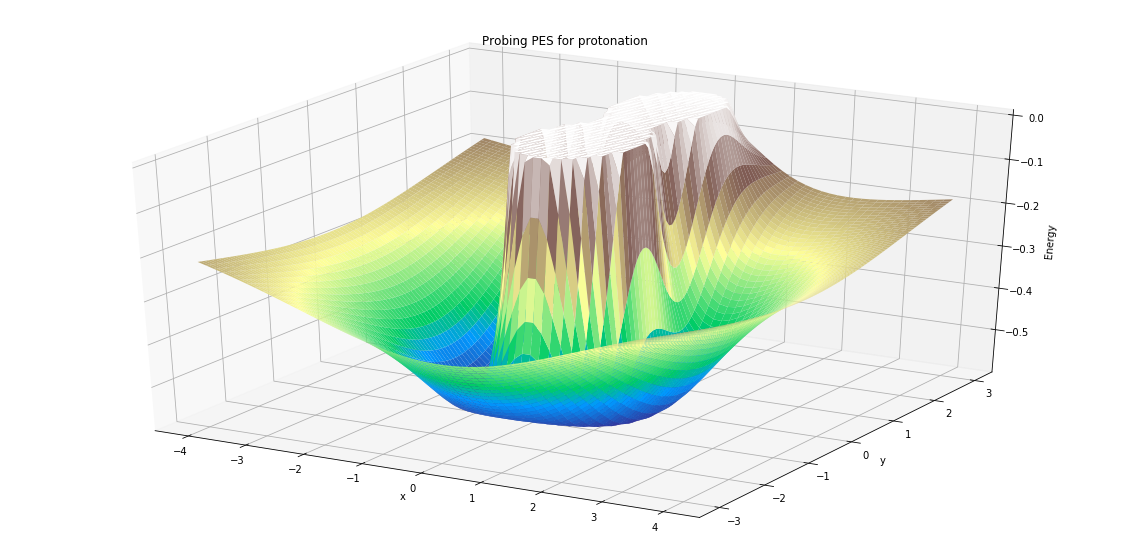

In [62]:
fig=plt.figure(figsize=(20, 10))
#ax = plt.axes(projection=’3d’)
ax =fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap="terrain" ,edgecolor=None)
ax.set(xlabel='x', ylabel='y', zlabel='Energy',title="Probing PES for protonation")

In [63]:
from matplotlib import cm
colormap = cm.coolwarm
znorm = Z - Z.min()
znorm /= znorm.ptp()
znorm.min(), znorm.max()
color = colormap(znorm)

In [64]:
ipv.figure()
mesh = ipv.plot_surface(X, Y, 100*Z, color=color[...,:3])
ipv.show()

In [65]:
HF,prot_site

(<pyscf.gto.mole.Mole at 0x7ffb50445fd0>,
 array([ 8.35466562e-07,  1.36412469e+00, -7.38240896e-01]))

# How to develop the basis functions or do none.


In [66]:
pHF=FcM(fcs=[0,0,-1],atom="F 0 0 0;H 0 0 1.695741; H {} {} {}".format(prot_site[0],prot_site[1],prot_site[2]),unit="bohr",
          basis={"H":"pc-2",'F':bse.get_basis("pcX-2",fmt="nwchem",elements=[9])},charge=1,verbose=4)
pHF.charge=0

System: uname_result(system='Linux', node='ubuntudesk', release='4.15.0-55-generic', version='#60-Ubuntu SMP Tue Jul 2 18:22:20 UTC 2019', machine='x86_64', processor='x86_64')  Threads 4
Python 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy 1.16.2  scipy 1.2.1
Date: Mon Jan 11 23:46:20 2021
PySCF version 1.7.5.1
PySCF path  /home/administrator/anaconda3/lib/python3.7/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 3
[INPUT] num. electrons = 10
[INPUT] charge = 1
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = bohr
[INPUT]  1 F      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr
[INPUT]  2 H      0.000000000000   0.000000000000   0.897347492823 AA    0.000000000000   0.000000000000   1.695741000000 Bohr
[INPUT]  3 H      0.000000442110   0.721863700123  -0.390660258469 AA    0.000000835467   1.364124692497  -0.738240896258 Bo

In [67]:
pHF.atom_charges(),pHF.nelec

(array([9., 1., 0.]), (5, 5))

In [68]:
pHFmf=scf.RHF(pHF)

In [69]:
pHF.nao

73

In [70]:
pdm=np.zeros([pHF.nao,pHF.nao])
pdm[:HF.nao,:HF.nao]=dm
pdm.shape

(73, 73)

In [71]:
pHFmf=scf.RHF(pHF)
pHFmf.max_cycle=1
pHFmf.scf(dm0=pdm,maxit=0,verbose=4)



******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 1
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/administrator/Documenti/APDFT/prototyping/hessian/AAFF/3_Example_of_geom_relax/tmpol20xmnn
max_memory 4000 MB (current use 266 MB)
Set gradient conv threshold to 3.16228e-05
init E= -100.065540168732
  HOMO = -0.650730820612021  LUMO = 0.0998724203596796
cycle= 1 E= -100.065862352446  delta_E= -0.000322  |g|= 0.00538  |ddm|= 0.0917
SCF not converged.
SCF energy = -100.065862352446


-100.06586235244633

In [72]:
pHFmf=scf.RHF(pHF)
pHFmf.dm=pdm
pHFmf.build()

In [73]:
pHFmf.mo_occ=np.zeros(pHF.nao)
pHFmf.mo_occ[:HF.nao]=mfhf.mo_occ
pHFmf.mo_energy=np.zeros(pHF.nao)
pHFmf.mo_energy[:HF.nao]=mfhf.mo_energy
pHFmf.mo_coeff=np.zeros([pHF.nao,pHF.nao])
pHFmf.mo_coeff[:HF.nao,:HF.nao]=mfhf.mo_coeff

In [74]:
pHFmf.make_rdm1()

array([[4.29749661e-07, 3.32472456e-06, 1.71002659e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.32472456e-06, 2.57214717e-05, 1.32294853e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.71002659e-05, 1.32294853e-04, 6.80444366e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [75]:
af=aaff(pHFmf,[-1,0,1])+alc_deriv_grad_nuc(pHF,[-1,0,1])

In [76]:
phfc=pHF.atom_coords()*bohr2ang

In [77]:
from berny import Berny, geomlib, coords,Geometry

In [78]:
pbg=Geometry(['O','H','H'],phfc)

In [79]:
b=Berny(pbg,debug=True)

In [80]:
b.send((mfhf.e_tot,af))

{'geom': <Geometry 'H2O'>,
 'params': {'gradientmax': 0.00045,
  'gradientrms': 0.00015,
  'stepmax': 0.0018,
  'steprms': 0.0012,
  'trust': 0.3,
  'dihedral': True,
  'superweakdih': False},
 'trust': 0.3,
 'coords': <InternalCoords "bonds: 2, angles: 1, dihedrals: 0">,
 'H': array([[0.54502214, 0.        , 0.        ],
        [0.        , 0.5839373 , 0.        ],
        [0.        , 0.        , 0.23574723]]),
 'weights': array([1.21116031, 1.29763844, 1.12068348]),
 'future': Point(q=array([1.72184678, 1.84993773, 2.06685429]), E=None, g=None),
 'first': False,
 'interpolated': Point(q=array([1.695741  , 1.55107569, 2.06684494]), E=-100.06554016873241, g=array([-3.52924909e-02, -4.15661786e-01, -9.94190104e-06])),
 'predicted': Point(q=array([1.72184684, 1.84993767, 2.06685448]), E=-100.16442309681395, g=None),
 'previous': Point(q=array([1.695741  , 1.55107569, 2.06684494]), E=-100.06554016873241, g=array([-3.52924909e-02, -4.15661786e-01, -9.94190104e-06])),
 'best': Point(q=arr

In [81]:
q=np.array([1.72184679, 1.84993778, 2.06685607])  # bd H1_O,bd H2_O, angle (H-O-H) -- Bohr,radians

In [82]:
norm(phfc[1])*ang2bohr,norm(phfc[2])*ang2bohr,np.arccos((phfc[1].dot(phfc[2])/norm(phfc[1])/norm(phfc[2])))

(1.6957409999672617, 1.5510756904466094, 2.0668449436482366)

In [83]:
pbg.coords,phfc

(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  8.97347493e-01],
        [ 4.42109865e-07,  7.21863700e-01, -3.90660258e-01]]),
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  8.97347493e-01],
        [ 4.42109865e-07,  7.21863700e-01, -3.90660258e-01]]))

In [85]:
OH2=gto.M(atom="O 0 0 0;H 0 -0.15229 1.76907; H 0   1.7401 -0.35319",unit="bohr",
            basis={"H":"pc-2",'O':bse.get_basis("pcX-2",fmt="nwchem",elements=[8])})
mfoh2 = scf.RHF(OH2)
mfoh2.scf()

converged SCF energy = -76.0633193329878


-76.06331933298785

In [ ]:
def V_tot_h2o(coords):
    return